# Olympian deities

![Wikipedia - Twelve Olympians](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Greek_-_Procession_of_Twelve_Gods_and_Goddesses_-_Walters_2340.jpg/799px-Greek_-_Procession_of_Twelve_Gods_and_Goddesses_-_Walters_2340.jpg)

Can you identify the twelve Olympians? I wanted to see if a convolutional neural network would be able to classify between the great gods and goddesses of ancient Greek mythology.

Right away, I knew this would not be an easy problem. There are so many depictions of each deity throughout history. One artist's image of Zeus would look totally different than another representation of the same god. In other words, the variability within each class is high. However, humans would be able to identify the god or goddess by noticing key symbolism. For example, Zeus is often depicted with a lightning bolt. Poseidon has his trident. Athena is often associate with an owl and Apollo with his lyre. It would be interesting to find whether a neural network would be able to pick up on these clues.

Note: Although their are twelve Olympians, there are several lists on which twelve are included. I have decided to include thirteen deities.

## Setup

Start by setting up Jupyter Notebook, importing the fastai library, and seeding the random function.

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.vision import *

np.random.seed(42)

## Load dataset

I used DuckDuckGo image search to create my dataset. The `imgurls/ddg_images` folder contains a text file for each class with a list of URLs. The files were created using the following JavaScript snippet in the browser's web tools:

```js
var urls=Array.from(document.querySelectorAll(".tile--img__img")).map(el=>el.hasAttribute("data-src")?el.getAttribute("src"):el.getAttribute("data-src")).filter(l=>l!=null).map(l=>"https:"+l).join("\n");
var a = document.createElement("a");a.download = "filename.txt";a.href = "data:text/csv;charset=utf-8,"+urls;a.click();
```

In [7]:
imgurls = Path("imgurls/ddg_images")
datasets = Path("datasets/ddg_images")

In [5]:
imgurls.ls()

[PosixPath('imgurls/ddg_images/artemis.txt'),
 PosixPath('imgurls/ddg_images/poseidon.txt'),
 PosixPath('imgurls/ddg_images/athena.txt'),
 PosixPath('imgurls/ddg_images/hermes.txt'),
 PosixPath('imgurls/ddg_images/ares.txt'),
 PosixPath('imgurls/ddg_images/hera.txt'),
 PosixPath('imgurls/ddg_images/zeus.txt'),
 PosixPath('imgurls/ddg_images/aphrodite.txt'),
 PosixPath('imgurls/ddg_images/apollo.txt'),
 PosixPath('imgurls/ddg_images/hephaestus.txt'),
 PosixPath('imgurls/ddg_images/demeter.txt'),
 PosixPath('imgurls/ddg_images/hestia.txt'),
 PosixPath('imgurls/ddg_images/dionysus.txt')]

I create a list of classes based on the file names.

In [6]:
classes = [p.stem for p in imgurls.ls()]
classes

['artemis',
 'poseidon',
 'athena',
 'hermes',
 'ares',
 'hera',
 'zeus',
 'aphrodite',
 'apollo',
 'hephaestus',
 'demeter',
 'hestia',
 'dionysus']

For each class, I created a folder in the `datasets` directory. Then looped through each class to download and verify the images.

In [7]:
for c in classes:
    (datasets / c).mkdir(parents=True, exist_ok=True)

In [8]:
for c in classes:
    download_images(f"{imgurls/c}.txt", datasets / c)

In [9]:
for c in classes:
    verify_images(datasets / c, delete=True)

## View data

With the data loaded in folders, created an `ImageDataBunch` to hold the data.

In [8]:
data = ImageDataBunch.from_folder(
    datasets,
    train=".",
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4,
).normalize(imagenet_stats)

Alternatively, if using the cleaned up version of the data, load the data from the CSV. See the [Data cleaning](#Data-cleaning) section at the end.

In [ ]:
data = ImageDataBunch.from_csv(
    dataset,
    csv_labels="cleaned.csv",
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4,
).normalize(imagenet_stats)

Display information about the number of classes, the classes, number of training samples, and number of validation samples.

In [12]:
data.c, data.classes, len(data.train_ds), len(data.valid_ds)

(13,
 ['aphrodite',
  'apollo',
  'ares',
  'artemis',
  'athena',
  'demeter',
  'dionysus',
  'hephaestus',
  'hera',
  'hermes',
  'hestia',
  'poseidon',
  'zeus'],
 5856,
 1463)

Display some sample images.

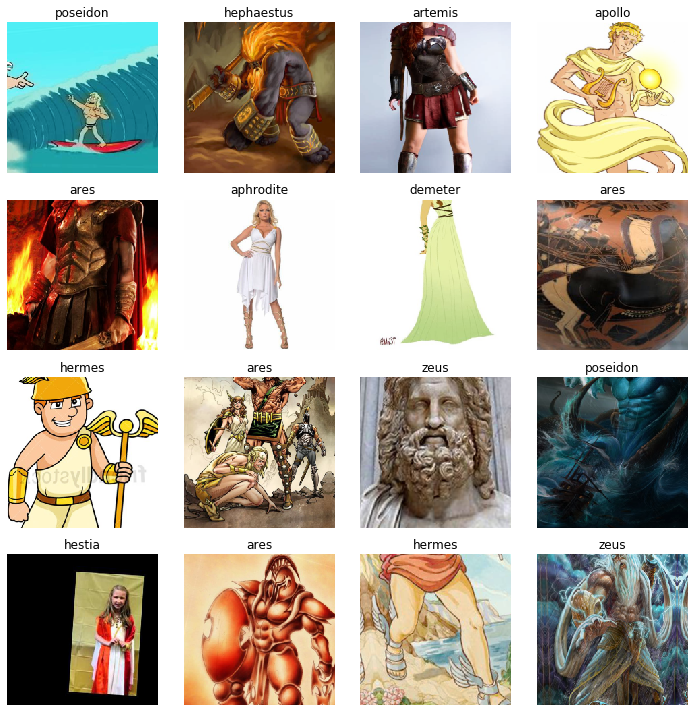

In [13]:
data.show_batch(rows=4, figsize=(10, 10))

## Training: ResNet34

Time to start training. Starting with the ResNet34 model.

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


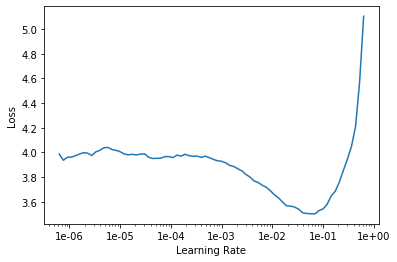

In [15]:
learn.lr_find()
learn.recorder.plot()

Default learning rate looks good. Let's go ahead and train.

In [26]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,3.140321,1.933644,0.606288,00:45
1,2.343928,1.580325,0.475735,00:45
2,1.882782,1.503403,0.451128,00:45
3,1.660460,1.381164,0.414217,00:45
4,1.517200,1.317678,0.401230,00:45
5,1.387321,1.257552,0.381408,00:46
6,1.230067,1.214429,0.362269,00:45
7,1.146430,1.177071,0.343814,00:45
8,1.065894,1.157852,0.341763,00:46
9,1.033686,1.159268,0.342447,00:46


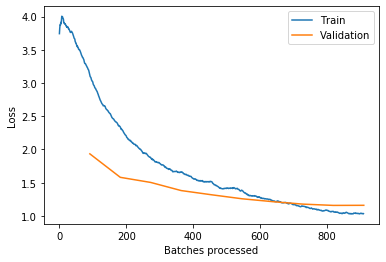

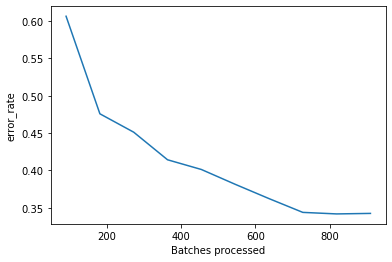

In [27]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

Based on these graphs, it looks like we acheived close to optimal performance with this dataset and architecture.

In [28]:
learn.save("stage-1")

## Training: ResNet34 unfreezing and fine-tuning

Let's see if fine-tuning will help.

In [29]:
learn.load("stage-1")
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


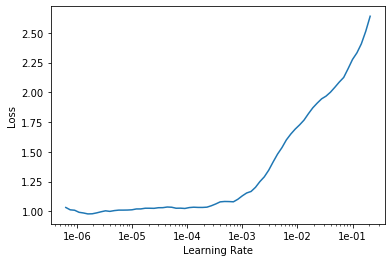

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(5, max_lr=slice(3e-6, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.998504,1.127473,0.321258,01:02
1,0.961965,1.070315,0.301435,01:03
2,0.845089,1.028929,0.293233,01:03
3,0.743742,1.004273,0.285714,01:03
4,0.690039,1.003269,0.287081,01:03


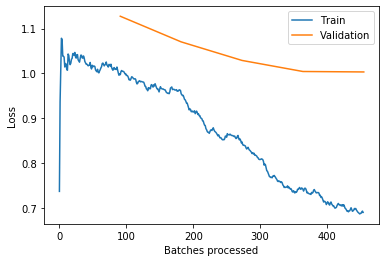

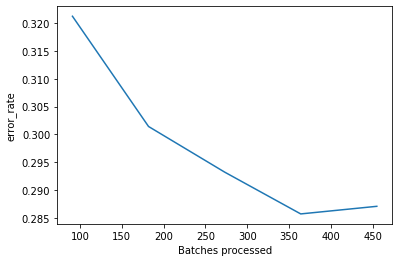

In [32]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

Yes, fine-tuning seems to help some. Also, looks like we're beginning to overfit after four cycles.

In [33]:
learn.save("stage-2")

## Training: ResNet50

For practice, let's try a bigger network.

In [40]:
data = ImageDataBunch.from_folder(
    datasets,
    train=".",
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4,
    bs=32,
).normalize(imagenet_stats)

In [41]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


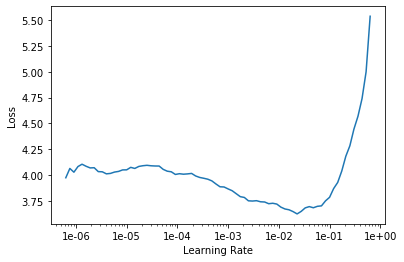

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.544664,1.750054,0.508544,01:44
1,2.058737,1.553397,0.468900,01:43
2,1.755551,1.401868,0.425837,01:43
3,1.577416,1.259166,0.380041,01:43
4,1.420091,1.198383,0.352016,01:43
5,1.212862,1.088002,0.319891,01:43
6,1.054661,1.063313,0.314422,01:43
7,0.957528,1.031150,0.308271,01:43
8,0.824036,0.996583,0.286398,01:43
9,0.811391,0.989064,0.284347,01:43


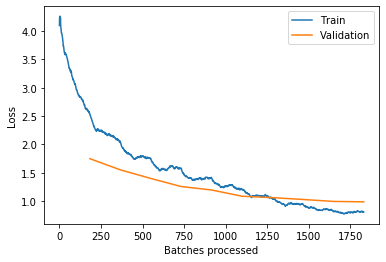

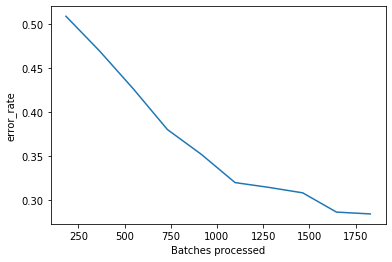

In [45]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

Able to acheive similar performance to fine-tuning the ResNet34 model. But took much longer to train. Let's stick with the ResNet34 model for now.

In [46]:
learn.save("stage-1-50")

## Interpretation

Let's try to understand how well our model did.

In [10]:
learn.load("stage-2")
interp = ClassificationInterpretation.from_learner(learn)

In [11]:
interp.most_confused(min_val=5)

[('hera', 'demeter', 15),
 ('artemis', 'apollo', 13),
 ('hera', 'aphrodite', 9),
 ('zeus', 'hera', 9),
 ('demeter', 'aphrodite', 8),
 ('hera', 'athena', 8),
 ('aphrodite', 'apollo', 7),
 ('dionysus', 'hermes', 7),
 ('hestia', 'demeter', 7),
 ('aphrodite', 'dionysus', 6),
 ('apollo', 'artemis', 6),
 ('ares', 'artemis', 6),
 ('hephaestus', 'ares', 6),
 ('hermes', 'apollo', 6),
 ('hermes', 'dionysus', 6),
 ('hestia', 'aphrodite', 6),
 ('hestia', 'artemis', 6),
 ('hestia', 'hera', 6),
 ('poseidon', 'apollo', 6),
 ('aphrodite', 'demeter', 5),
 ('apollo', 'hermes', 5),
 ('ares', 'hephaestus', 5),
 ('artemis', 'demeter', 5),
 ('demeter', 'hera', 5),
 ('dionysus', 'demeter', 5),
 ('hephaestus', 'dionysus', 5),
 ('hera', 'hestia', 5),
 ('hera', 'zeus', 5),
 ('hermes', 'ares', 5),
 ('hermes', 'artemis', 5),
 ('poseidon', 'zeus', 5),
 ('zeus', 'apollo', 5)]

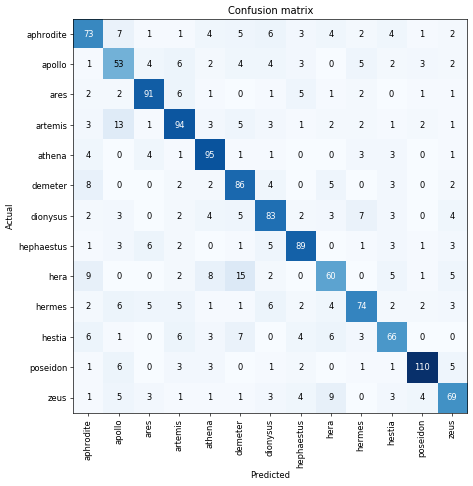

In [14]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

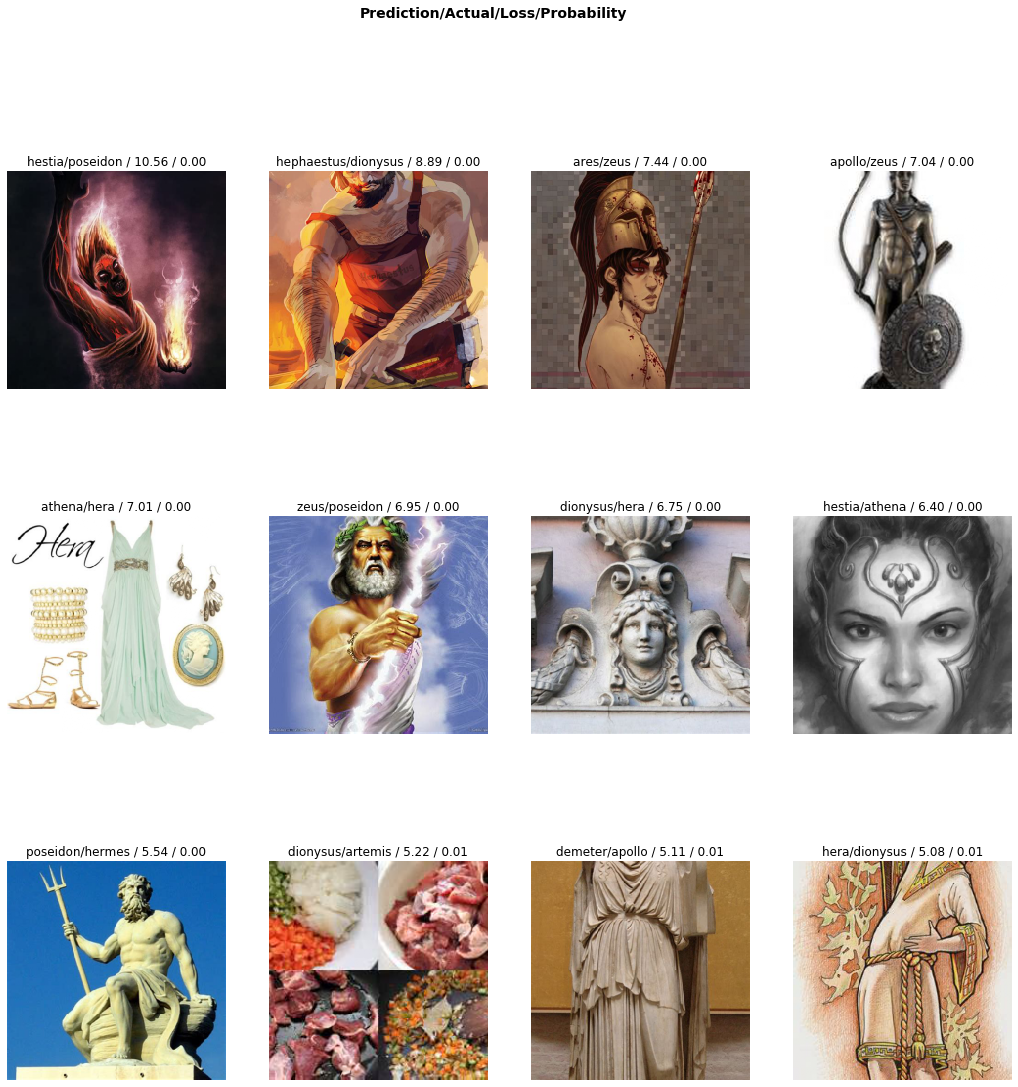

In [53]:
interp.plot_top_losses(12, figsize=(18, 18))

For some of these, it looks like the data is just mis-classified. For example, on the first row, second column, this was correctly predicted as Hephaestus, but was labelled Dionysus. There is also a not of "noise" in the data. So it is possible that we could acheive even better performance by cleaning up the data.

## Data cleaning

Here are the steps to run the image cleaner widget. Note: this only works in the classic Jupyter Notebook interface and not Jupyter Lab.

In [ ]:
from fastai.widgets import *

Use the cell below for the first time you're cleaning the data. Otherwise, load the data from the CSV.

In [ ]:
# data = ImageDataBunch.from_folder(
#     dataset,
#     train=".",
#     valid_pct=0,
#     ds_tfms=get_transforms(),
#     size=224,
#     num_workers=4,
#     bs=32,
# ).normalize(imagenet_stats)

In [ ]:
data = ImageDataBunch.from_csv(
    dataset,
    csv_labels="cleaned.csv",
    valid_pct=0.2,
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4,
).normalize(imagenet_stats)

In [ ]:
learn_clean = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn_clean.load("stage-2")

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_clean)

In [ ]:
# DO NOT RUN THIS IN JUPYTER LAB, USE JUPYTER NOTEBOOK
ImageCleaner(ds, idxs, dataset)